# Transformations Notebook

This *notebook* contains illustrative code representing all the transformations performed by our solution, starting from the Digital Elevation Model and the remaining data (school locations, populations by geographic zones, etc...).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from osgeo import gdal
from os.path import join

INPUT_FOLDER = "D:/Donnees/Others/geographic/bangladesh"

## Definition of flooded zones

Here, we implement the method that takes the Digital Elevation Model in input as well as sea elevation value (expressed in meter) and that returns the corresponding flooded zones.

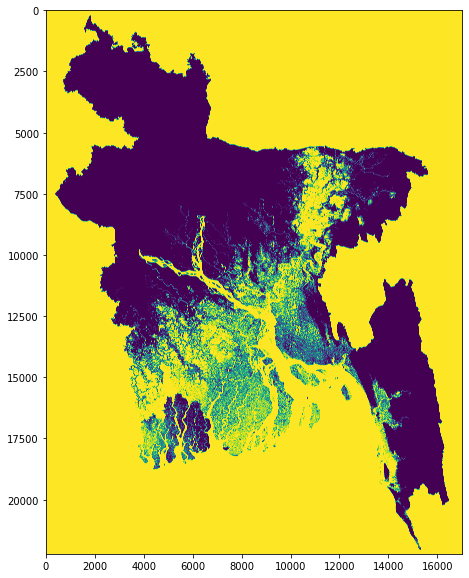

In [2]:
from matplotlib.image import AxesImage

elevation = 5
filepath = join(INPUT_FOLDER, "elevation.tif")

# turn TIF image into data array
dem = gdal.Open(filepath).ReadAsArray()

# 1st method : every altitude below elevation is flooded
mask = dem <= elevation

fig = plt.figure(figsize=(10, 10))
_ = plt.imshow(mask)

### WIP !!

This is an attempt to export the data corresponding to the flooded zones computed in the previous cell in a GTIF image containing the same metadata as the input GTIF image used for the DEM. This will allow to convert these extracted TIF images to XYZ coordinates and use them to compute the flooded schools from their coordinates.

In [3]:
def get_flooded_zones(elevation, dem: np.array) -> np.array:
    r, c = dem.shape
    output = dem.flatten()
    output[(output != -9999) & (output <= elevation)] = 1
    output[(output != -9999) & (output > elevation)] = 0
    return output.reshape(r, c)

def copyTIF(input_file, new_data, output_file):
    '''Creates a copy of a n-band raster with values from array

    Arguments:

        template: Path to template raster
        arr: Value array with dimensions (r,c,3)
        filename: Output filename for new raster 
    '''
    # Open file
    raster = gdal.Open(input_file)

    # Get geotiff driver
    driver = gdal.GetDriverByName('GTiff')

    # Create new raster
    r = driver.Create(output_file, raster.RasterXSize, raster.RasterYSize, 1, gdal.GDT_Byte, ['COMPRESS=LZW'])

    # Set metadata
    r.SetGeoTransform(raster.GetGeoTransform())
    r.SetProjection(raster.GetProjection())
    raster.GetRasterBand(1).WriteArray(new_data)

    # Close datasets
    r = None

floods = get_flooded_zones(elevation=1.2, dem=dem)
copyTIF(
    input_file=join(INPUT_FOLDER, "elevation.tif"),
    new_data=floods,
    output_file=join(INPUT_FOLDER, "output", "floods.tif")
)

## Calculation of flooded schools

In this section, we will compute the list of flooded schools from the flooded zones computed in the previous section and the coordinates of the considered schools.

We start by importing the XY coordinates, in the WGS84 (EPSG:4326) referential, of all the considered schools.

In [4]:
schools = pd.read_csv(join(INPUT_FOLDER, "schools.csv"), header=0, sep=";", decimal=".")

schools = (
    schools
    .where((schools != "#VALEUR!").all(axis=1))
    .dropna()
    .astype(float)
)

schools.info()
schools.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77974 entries, 0 to 78144
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   x_clean  77974 non-null  float64
 1   y_clean  77974 non-null  float64
dtypes: float64(2)
memory usage: 1.8 MB


,x_clean,y_clean
0,90.148824,22.959532
1,90.158291,22.919375
2,90.158166,22.934544
3,90.149452,22.940150
4,90.163619,22.941863
